**IMPORTS**

In [24]:
!pip install torchinfo
!pip install livelossplot

In [26]:
import torch
print(torch.__version__)

1.11.0


In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn import BCELoss, BCEWithLogitsLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from torchinfo import summary
from livelossplot import PlotLosses

**Preparar os Dados**

In [28]:
PATH_TRAINING = 'train.csv'
PATH_TEST = 'test.csv'

device = torch.device("cpu")

EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001

In [52]:
class CSVDataset(Dataset):
    
    def __init__(self, path):
        df = pd.read_csv(path, header=None)
        self.X = df.values[1:,1:]
        self.X = np.delete(self.X,0,1) #remover a idade
        #print(self.X)
        self.y = df.values[1:, 1]
        self.X = self.X.astype('float32')
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))
        self.X = standardize(self.X)
        self.X = normalize(self.X)
        #print(self.X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]] 
    
    def getXy (self):
        return self.X, self.y
  
    def get_splits(self, n_test=0.33): 
        test_size = round(n_test * len(self.X)) 
        train_size = len(self.X) - test_size 
        return random_split(self, [train_size, test_size])
    
    def standardize(X):
        Xmed = np.mean(X, axis = 0)
        Xsigma = np.std(X, axis = 0)
        return (X-Xmed)/Xsigma

    def normalize(X):
        Xmax = np.max(X, axis = 0)
        Xmin = np.min(X, axis = 0)
        return (X-Xmin)/(Xmax-Xmin)

In [53]:
def prepare_data(path):
        dataset = CSVDataset(path)
        train, test = dataset.get_splits()
        train_dl = DataLoader(train, batch_size=len(train), shuffle=True)
        test_dl = DataLoader(test, batch_size=1024, shuffle=False)
        train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
        test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
        return train_dl, test_dl, train_dl_all, test_dl_all
        
train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data(PATH_TRAINING)

x,y = next(iter(train_dl))
print(x.shape, y.shape)
x,y = next(iter(test_dl))
print(x.shape, y.shape)

torch.Size([75, 2]) torch.Size([75, 1])
torch.Size([37, 2]) torch.Size([37, 1])


**Visualizar os Dados**

In [54]:
def visualize_data(path):
    df = pd.read_csv(path, header=None)
    display(df)
    idades = pd.DataFrame(df.values[1:,1].astype('float32'))
    print('-------------- Distribuição das idades -------------')
    print(idades.describe())
    print('-------------- Informação -------------------')
    print(df.info())
    print('---------------------------------------------')

def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}")
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    #print(y)
    x, y = next(iter(test_dl))
    print(f"Shape tensor batch casos teste, input: {x.shape}, output: {y.shape}")
    #print(y)
    
visualize_data(PATH_TRAINING)
visualize_dataset(train_dl, test_dl)

,0,1,2,3
0,id,age,sex,education
1,1,13,1,7
2,2,14,0,8
3,3,15,1,9
4,4,15,1,9
...,...,...,...,...
108,108,77,1,4
109,109,67,0,4
110,110,55,0,4
111,111,76,1,3


-------------- Distribuição das idades -------------
                0
count  112.000000
mean    44.312500
std     22.642157
min     13.000000
25%     20.000000
50%     51.500000
75%     65.250000
max     79.000000
-------------- Informação -------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       113 non-null    object
 1   1       113 non-null    object
 2   2       113 non-null    object
 3   3       113 non-null    object
dtypes: object(4)
memory usage: 3.7+ KB
None
---------------------------------------------
Quantidade de casos de Treino:75
Quantidade de casos de Teste:37
Shape tensor batch casos treino, input: torch.Size([75, 2]), output: torch.Size([75, 1])
Shape tensor batch casos teste, input: torch.Size([37, 2]), output: torch.Size([37, 1])


casos_treino: 75
idadesBaixas_Train:  30
idadesMedias_Train:  16
idadesAltas_Train:  29
casos_test: 37
idadesBaixas_Test:  18
idadesMedias_Test:  7
idadesAltas_Test:  12


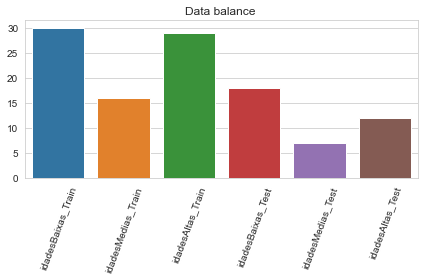

In [19]:
def visualize_holdout_balance(y_train, y_test):
    _, y_train = next(iter(train_dl_all))
    _, y_test = next(iter(test_dl_all))
    sns.set_style('whitegrid')
    casos_treino=len(y_train)
    casos_test=len(y_test)

    #Filtrar as idades por intervalos (usando numpy arrays)
    np_treino = y_train.numpy()
    #Filtrar as idades entre 13 e 35
    idadesBaixasArr = []
    for idade in np_treino:
        if idade >= 13.0 and idade <= 35.0:
            idadesBaixasArr.append(True)
        else:
            idadesBaixasArr.append(False)
    #Filtrar as idades entre 36 e 58
    idadesMediasArr = []
    for idade in np_treino:
        if idade >= 36.0 and idade <= 58.0:
            idadesMediasArr.append(True)
        else:
            idadesMediasArr.append(False)
    #Filtrar as idades entre 59 e 79
    idadesAltasArr = []
    for idade in np_treino:
        if idade >= 59.0 and idade <= 79.0:
            idadesAltasArr.append(True)
        else:
            idadesAltasArr.append(False)
  
    #Contagem das idades de treino
    idadesBaixas_Train=np.count_nonzero(idadesBaixasArr)
    idadesMedias_Train=np.count_nonzero(idadesMediasArr)
    idadesAltas_Train=np.count_nonzero(idadesAltasArr)
        
    #Filtrar as idades por intervalos (usando numpy arrays)
    np_teste = y_test.numpy()
    #Filtrar as idades entre 13 e 35
    idadesBaixasArr = []
    for idade in np_teste:
        if idade >= 13.0 and idade <= 35.0:
            idadesBaixasArr.append(True)
        else:
            idadesBaixasArr.append(False)
    #Filtrar as idades entre 36 e 58
    idadesMediasArr = []
    for idade in np_teste:
        if idade >= 36.0 and idade <= 58.0:
            idadesMediasArr.append(True)
        else:
            idadesMediasArr.append(False)
    #Filtrar as idades entre 59 e 79
    idadesAltasArr = []
    for idade in np_teste:
        if idade >= 59.0 and idade <= 79.0:
            idadesAltasArr.append(True)
        else:
            idadesAltasArr.append(False)
        
    idadesBaixas_Test=np.count_nonzero(idadesBaixasArr)
    idadesMedias_Test=np.count_nonzero(idadesMediasArr)
    idadesAltas_Test=np.count_nonzero(idadesAltasArr)
  
    print("casos_treino:",casos_treino)
    print("idadesBaixas_Train: ", idadesBaixas_Train)
    print("idadesMedias_Train: ", idadesMedias_Train)
    print("idadesAltas_Train: ", idadesAltas_Train)
  
    print("casos_test:",casos_test)
    print("idadesBaixas_Test: ", idadesBaixas_Test)
    print("idadesMedias_Test: ", idadesMedias_Test)
    print("idadesAltas_Test: ", idadesAltas_Test)
  
    grafico=sns.barplot(
      x=['idadesBaixas_Train','idadesMedias_Train', 'idadesAltas_Train',
         'idadesBaixas_Test', 'idadesMedias_Test', 'idadesAltas_Test'], 
      y=[idadesBaixas_Train,idadesMedias_Train,idadesAltas_Train, idadesBaixas_Test, idadesMedias_Test, idadesAltas_Test])
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 

visualize_holdout_balance(train_dl_all, test_dl_all)

**Preparar o Modelo**

In [55]:
class MLP(Module):
    
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.hidden3 = Linear(8, 1)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid()
        
    def forward(self, X): 
        X = self.hidden1(X) 
        X = self.act1(X) 
        X = self.hidden2(X) 
        X = self.act2(X) 
        X = self.hidden3(X) 
        X = self.act3(X) 
        return X

model = MLP(2)
print(summary(model, input_size=(BATCH_SIZE, 2), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      --                        --
├─Linear: 1-1                            [32, 10]                  30
├─ReLU: 1-2                              [32, 10]                  --
├─Linear: 1-3                            [32, 8]                   88
├─ReLU: 1-4                              [32, 8]                   --
├─Linear: 1-5                            [32, 1]                   9
├─Sigmoid: 1-6                           [32, 1]                   --
Total params: 127
Trainable params: 127
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01


MLP(
  (hidden1): Linear(in_features=2, out_features=10, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=10, out_features=8, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=8, out_features=1, bias=True)
  (act3): Sigmoid()
)

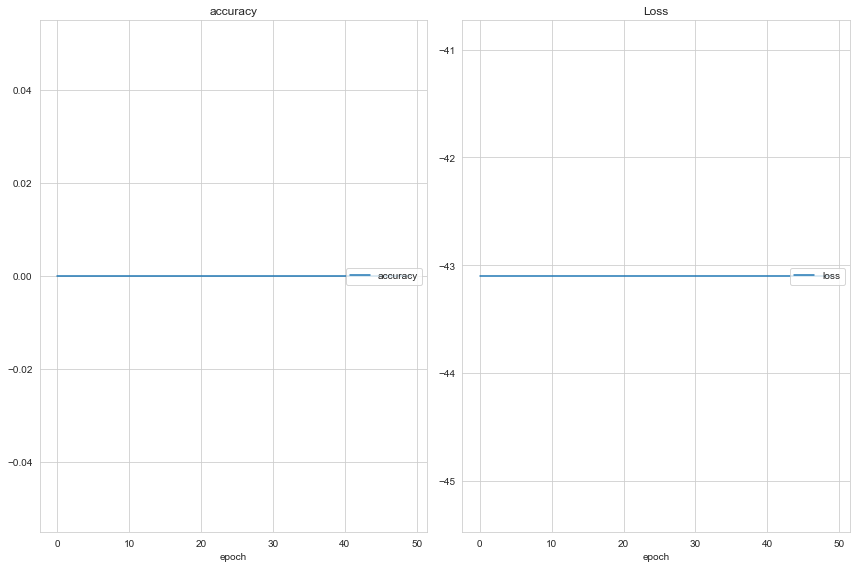

accuracy
	accuracy         	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	loss             	 (min:  -43.100, max:  -43.100, cur:  -43.100)


In [57]:
def train_model(train_dl, model):
    liveloss = PlotLosses()
    criterion = BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        logs = {}
        epoch_loss = 0
        epoch_acc = 0
        for i, (inputs, targets) in enumerate(train_dl):
            optimizer.zero_grad()
            yprev = model(inputs)
            loss = criterion(yprev, targets)
            acc = accuracy_score(targets.numpy(), np.argmax(yprev.detach().numpy(), axis=1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        print(f'Epoch {epoch:03}: | Loss: {epoch_loss/len(train_dl):.5f} | Acc: {epoch_acc/len(train_dl):.3f}')      
        logs['loss'] = epoch_loss
        logs['accuracy'] = epoch_acc/len(train_dl)
        liveloss.update(logs)
        liveloss.send()
            
train_model(train_dl, model)

In [59]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        print(inputs,labels)
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = yprev.round()
        predictions.append(yprev)
        actual_values.append(actual)
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return predictions, actual_values

predictions, actual_values = evaluate_model(test_dl, model)
acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
acertou=0
falhou = 0
for r,p in zip(actual_values, predictions): 
    print(f'real:{r} previsão:{p}')  
    if r==p: acertou+=1
    else: falhou+=1
print(f'acertou:{acertou} falhou:{falhou}')
print(classification_report(actual_values,  predictions))

tensor([[0.0000, 0.2000],
        [0.0000, 0.2000],
        [1.0000, 0.4500],
        [0.0000, 0.5000],
        [0.0000, 0.6000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [1.0000, 0.2000],
        [0.0000, 0.4500],
        [0.0000, 0.8500],
        [1.0000, 0.6000],
        [1.0000, 0.5000],
        [0.0000, 0.6000],
        [0.0000, 0.2000],
        [0.0000, 0.3000],
        [1.0000, 0.5000],
        [0.0000, 0.8500],
        [0.0000, 0.6000],
        [1.0000, 0.3000],
        [1.0000, 0.7500],
        [0.0000, 0.4500],
        [1.0000, 0.3000],
        [0.0000, 0.7000],
        [1.0000, 0.8500],
        [1.0000, 0.6500],
        [1.0000, 0.8500],
        [1.0000, 0.2000],
        [1.0000, 0.8500],
        [1.0000, 0.2000],
        [0.0000, 0.8000],
        [1.0000, 0.2000],
        [0.0000, 0.2000],
        [0.0000, 0.8000],
        [1.0000, 0.4500],
        [0.0000, 0.6000],
        [1.0000, 0.1500],
        [1.0000, 0.0000]]) tensor([[68.],
        [65.],
       

/opt/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/DL/lib/python3.8/si